In [ ]:
# 사용자 정의 지표, 층, 모델

In [ ]:
# 후버 손실 함수를 지표로 사용

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.8433 - huber_fn: 1.1069
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7054 - huber_fn: 0.3065


In [ ]:
# 사용자 정의 지표

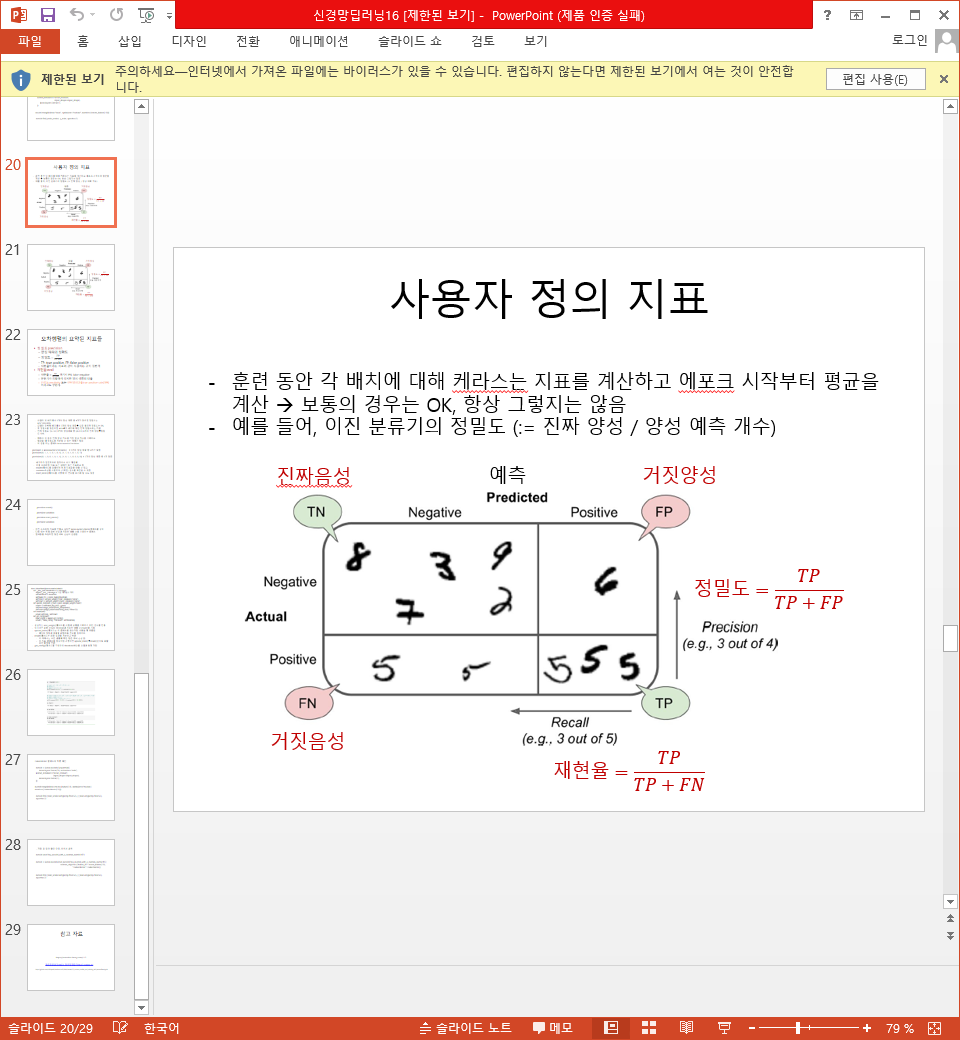

In [ ]:
# 지표에 정밀도 / 재현율 구현

In [ ]:
precision = keras.metrics.Precision()   # 5개의 양성 예측 중 4개가 맞음
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]) # 3개의 양성 예측 중 0개 맞음

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.result().numpy()

0.5

In [ ]:
# 스트리밍 지표를 만들고 싶다면 keras.metrics.Metric클래스를 상속

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리 
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros") # 이름(total)을 가지고 0으로 초기화 된 상태변수
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


In [ ]:
m = HuberMetric(2.)
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8873 - huber_metric_2: 0.8873
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2487 - huber_metric_2: 0.2487


In [ ]:
# 저장 후 읽어 들인 다음, 이어서 훈련


In [ ]:
model.save("my_model_with_a_custom_metric.h5")
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2261 - huber_metric_2: 0.2261
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2193 - huber_metric_2: 0.2193


In [ ]:
##################################################################################################################

In [ ]:
# 사용자 정의 층

In [ ]:
# 가중치가 필요 없는 사용자 정의 층
# 회귀 모델이 예측할 값이 양수이고 스케일이 매우 다른 경우 (예를 들어, 0.001, 10., 10000) 출력층에 
# 지수 함수를 추가하면 유용할 수 있습니다.

exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 2s 5ms/step - loss: 0.8072 - val_loss: 0.4295
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4348 - val_loss: 0.4019
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4215 - val_loss: 0.3728
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4160 - val_loss: 0.3878
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3728


0.3728318214416504

In [ ]:
# 가중치가 있는 층

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    
    # 사용될 때 호출
    # batch_input_shape = (32,8)
                  # batch_size / feature
    def build(self, batch_input_shape):
        # 기본 weight
        self.kernel = self.add_weight(
                                        # [8 , units]
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        
        # 편향
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}


In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

model.save("my_model_with_a_custom_layer.h5")
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.5700 - val_loss: 0.7315
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5011


In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.4678
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.4289
